In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import *
from sklearn.preprocessing import normalize
from scipy.spatial.distance import euclidean
from adjustText import adjust_text

In [12]:
dataset='all_beta_center_p001_20190621_500PCs'

# phenotypes to analyze
#phe_codes=['INI21001','HC221','HC326', 'INI5255','HC276','INI5098','HC22','BIN_FC1002247','QT_FC1001717','INI1160','INI21002','INI20030690','INI20030620','INI20030700','INI40030700','INI1498','QT_FC1001180','BIN2207','INI20016','INI78','INI20030790','INI20030850','INI20022','INI20414','BIN_FC5006152','FH1263','BIN_FC1001747','BIN_FC1006149','FH1044','HC376','BIN_FC10002453','cancer1003','HC125','INI134','INI30000','INI2734','QT_FC1002375','cancer1002']
phe_codes = ['BIN_FC1002247']
#phe_codes = ['BIN_FC1002247','INI5255','HC276','HC326','HC382','INI3148','HC221']

# for regression models
covariate=['age','sex']+['PC'+str(i+1) for i in range(4)]

# load data
z=np.load('/oak/stanford/groups/mrivas/projects/degas-risk/datasets/all_pop/tsvd/'+
           dataset+'.npz', 
          allow_pickle = True)
scores=pd.read_csv('/oak/stanford/groups/mrivas/projects/degas-risk/scorefiles/'+
                    dataset+'.sscore',
                   index_col='#IID',sep = "\t")
phenos=pd.read_csv('/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/master_phe/master.phe',
                     usecols=['IID']+phe_codes+covariate,
                     index_col='IID',
                     na_values=-9, sep = "\t")
npc=100 # z['D'].shape[0]

# analysis populations
val=set(pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/population-split/'+
                      'ukb24983_white_british_test.phe').iloc[:,0].tolist())

# phenotype names
with open('../../ukbb-tools/05_gbe/icdinfo.txt','r') as f:
    code_to_name = {line.split()[0]:line.split()[2].replace('_',' ').split('(')[0].capitalize() for line in f}

# program some special cases
#code_to_name['INI21001'] = 'Body mass index'
#code_to_name['HC294'] = 'Renal failure'
#code_to_name['HC326'] = 'Myocardial infarction'

/oak/stanford/groups/mrivas/anaconda/v3/envs/mrivas-env/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


<Figure size 432x288 with 0 Axes>

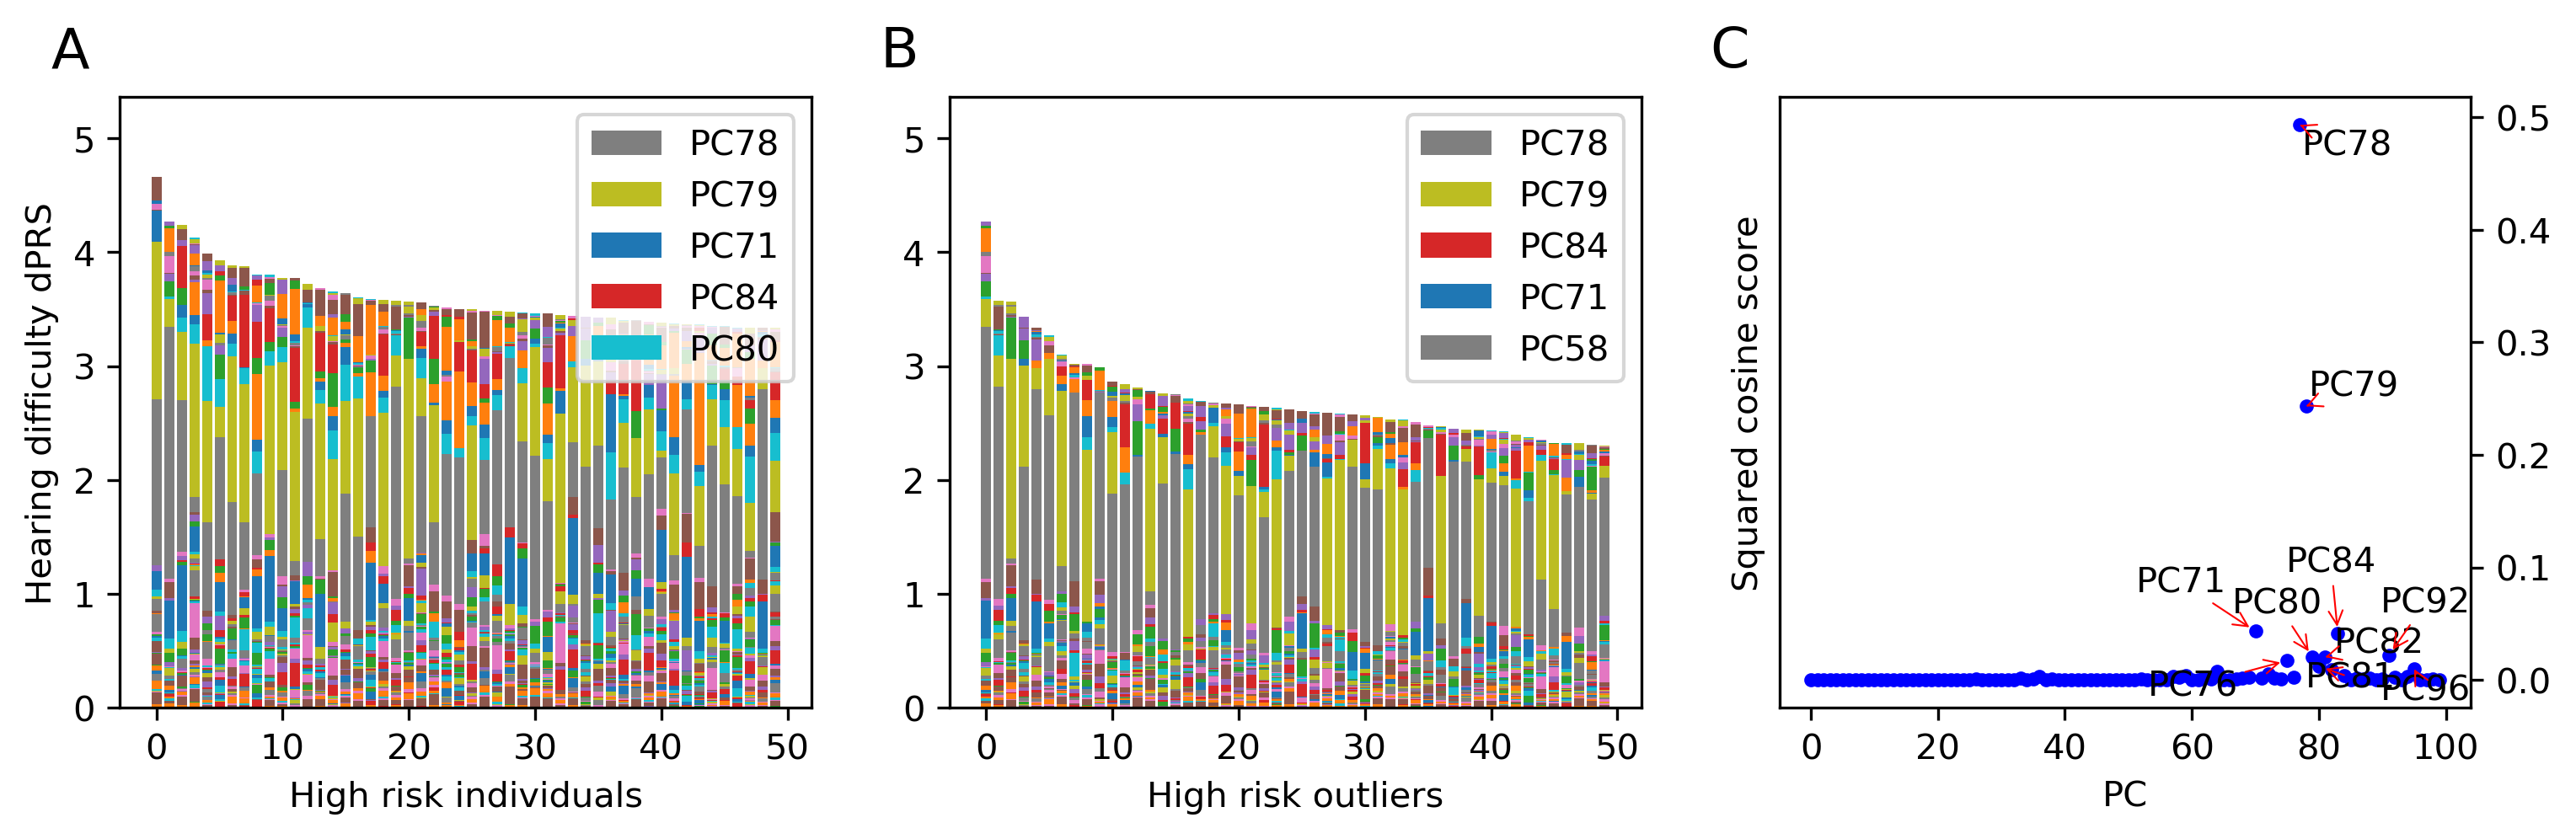

In [13]:
width = 3
plots = [None for _ in range(width * len(phe_codes))]
plt.close('all'); plt.clf()
fig = plt.figure(figsize=(5*width/1.25, 4*len(phe_codes)/1.25), dpi=300)
score_pcs=['SCORE{}_SUM'.format(pc+1) for pc in range(npc)]
profl_pcs=['PROF_PC{}'.format(pc+1) for pc in range(npc)]
for ix,phe_code in enumerate(phe_codes):
    for ix2 in range(width):
        plots[(width*ix)+ix2]=plt.subplot(len(phe_codes), width, width*ix + ix2 + 1)
    # scores and phenotypes
    phe_name=code_to_name[phe_code]
    df=phenos.loc[val,[phe_code]+covariate].dropna().merge(scores, left_index=True, right_index=True)
    n=df.shape[0]
    weights=z['V'][np.where(z['label_phe_code'] == phe_code),:].flatten()[:npc]
    df['SCORE']=zscore(df[score_pcs].dot(weights))
    df.sort_values(by='SCORE',ascending=False,inplace=True)
    
    # filter to cases for clustering binary traits
    if len(df[phe_code].value_counts()) == 2:
        is_bin=True
        # df=df[df[phe_code]==2]
    else:
        is_bin=False
    
    # do painting
    for pc in range(npc):
        df[profl_pcs[pc]]=(df[score_pcs[pc]] * weights[pc] * df['SCORE']).clip(lower=0)
    df[profl_pcs] = normalize(df[profl_pcs], norm='l1')

    # (A): paint highest risk individuals
    pc_plots=[]
    for pc in range(npc):
        pp=plots[(width*ix)].bar(np.arange(50), 
                                 df.iloc[:50,:][profl_pcs[pc]] * df.iloc[:50,:]['SCORE'],
                                 bottom=np.array(df.iloc[:50,:][profl_pcs[:pc]].sum(axis=1) * df.iloc[:50,:]['SCORE'])
                                 )
        pc_plots.append(pp)
    # axis labels and such
    plots[(width*ix)].set_ylim(0, 1.15*df['SCORE'].max())
    plots[(width*ix)].set_ylabel(phe_name+' dPRS')
    top5pc=np.argsort(df.iloc[:50,:]['SCORE'].dot(df.iloc[:50,:][profl_pcs])[:npc])[-5:][::-1]
    plots[(width*ix)].legend([pc_plots[i] for i in top5pc], ['PC'+str(i+1) for i in top5pc], loc=1)
    
    # (B): plot high risk outliers -- first compute mahalanobis distances on cluster profiles
    drp_centroid=df[profl_pcs].median()
    df['mahal']=df[profl_pcs].apply(lambda x: euclidean(x, drp_centroid), axis=1)
    m_star=df['mahal'].mean() + 2*df['mahal'].std()
    outliers=df.query('mahal > @m_star').index[:50]
    # make the same plot as A
    pc_plots=[]
    for pc in range(npc):
        pp=plots[(width*ix)+1].bar(np.arange(len(outliers)), 
                                   df.loc[outliers,profl_pcs[pc]] * df.loc[outliers,'SCORE'],
                bottom=np.array(df.loc[outliers,profl_pcs[:pc]].sum(axis=1) * df.loc[outliers,'SCORE'])
                                   )
        pc_plots.append(pp)
    # axis labels and such
    plots[(width*ix)+1].set_ylim(0, 1.15*df['SCORE'].max())
    top5pc=np.argsort(df.loc[outliers,'SCORE'].dot(df.loc[outliers,profl_pcs])[:npc])[-5:][::-1]
    plots[(width*ix)+1].legend([pc_plots[i] for i in top5pc], ['PC'+str(i+1) for i in top5pc])
    
    # (C): plot phenotype cosine score
    plots[(width*ix)+2].plot(np.arange(npc), weights**2/np.sum(weights**2), 'b.')
    plots[(width*ix)+2].set_ylabel('Squared cosine score')
    # add figure label, then label to PCs
    plots[(width*ix)+2].text(-.1, 1.05, chr((ix%len(phe_codes))+65+2*len(phe_codes)), 
                             fontsize=16, transform=plots[(width*ix)+2].transAxes)
    adjust_text([plots[(width*ix)+2].text(pc,(weights**2/np.sum(weights**2))[pc],'PC{}'.format(pc+1)) 
                       for pc in np.argsort(weights**2)[-10:]],
                arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    plots[(width*ix)+2].yaxis.tick_right()
    
    # add x axis labels to bottom
    if ix == len(phe_codes)-1:
        plots[(width*ix)+2].set_xlabel('PC')
        plots[(width*ix)+1].set_xlabel('High risk outliers')
        plots[(width*ix)].set_xlabel('High risk {}'.format('individuals' if is_bin else 'individuals'))
    
    # and figure labels to this round of plots
    for ix2 in range(width-1):
        plots[(width*ix)+ix2].text(-.1, 1.05, chr((ix%len(phe_codes))+65+ix2*len(phe_codes)), 
                                   fontsize=16, transform=plots[(width*ix)+ix2].transAxes)

plt.show()
fig.savefig("fig3hearing.pdf", bbox_inches='tight')